<a href="https://colab.research.google.com/github/andrewsiyoon/spiking-seRNN/blob/main/DVSGesture_RSNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install tonic

In [2]:
%%capture
# !git clone https://github.com/jeshraghian/snntorch
# %cd snntorch
# !python3 setup.py install
!pip install snntorch

In [3]:
#Imports -----

import torch, torch.nn as nn
import snntorch as snn
import numpy as np
import scipy 
import tonic

import random

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns

In [4]:
#Random seeds -----

random.seed(211)
torch.manual_seed(211)

In [5]:
#DVS Gesture -----

import tonic.transforms as transforms
from tonic import DiskCachedDataset
from torch.utils.data import DataLoader

#Define variables (batch size, sensor size)
batch_size = 32
data_path = '/data/DVSGesture'
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
sensor_size = tonic.datasets.DVSGesture.sensor_size

#Define transformations
frame_transform = tonic.transforms.Compose([transforms.DropEvent(p = 0.001), transforms.ToFrame(sensor_size=sensor_size, n_time_bins = 20)])

#Define training and test sets
DVS_train = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=True)
DVS_test = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=False)

#Create cached sets
cached_trainset = DiskCachedDataset(DVS_train, cache_path='./cache/DVSGesture/train')
cached_testset = DiskCachedDataset(DVS_test, cache_path='./cache/DVSGesture/test')

#Create dataloaders
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True, drop_last = True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), drop_last = True)

In [6]:
#Initialize membrane time constant distribution -----

tau_mem = 20e-3
dist_shape = 3
time_step = 0.5e-3

def clip_tc(x):
    clipped_tc = x.clamp_(0.7165, 0.995)
    return clipped_tc

def init_tc():
    dist_gamma = np.random.gamma(dist_shape, tau_mem / 3, 100)
    dist_beta = torch.from_numpy(np.exp(-time_step / dist_gamma))
    clipped_beta = clip_tc(dist_beta)
    return clipped_beta

In [7]:
#Model architecture -----

from snntorch import surrogate

#Size parameters
num_inputs = 128*128*2
num_hidden = 100
num_outputs = 11

#Network parameters
het_tau = init_tc().to(device)
hom_tau = 0.9753

#Optimization mechanism
spike_grad = surrogate.fast_sigmoid()

#Model definition
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        #Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.RLeaky(beta = het_tau, linear_features = num_hidden, learn_beta = True, spike_grad = spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta = hom_tau, spike_grad = spike_grad)

    def forward(self, x):

        #Initialize parameters
        spk1, mem1 = self.lif1.init_rleaky() #init_rleaky() creates a tuple [_SpikeTensor, _SpikeTensor], assigns each to mem1 and spk1
        mem2 = self.lif2.init_leaky() #init_leaky() creates a tensor _SpikeTensor 

        #Record final layer
        spk_rec = []
        mem_rec = []

        #Forward loop
        for step in range(data.size(0)): #Iterate over the number of time steps in each mini-batch
            batched_data = data[step].view(batch_size, num_inputs) #Reshape input tensor to [batch_size, num_inputs]
            cur1 = self.fc1(batched_data)
            spk1, mem1 = self.lif1(cur1, spk1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk_rec.append(spk2)
            mem_rec.append(mem2)

        #Convert final lists to tensors
        spk_rec = torch.stack(spk_rec)
        mem_rec = torch.stack(mem_rec)
        
        return spk_rec, mem_rec

net = Net().to(device)

Text(0.5, 0, 'ms')

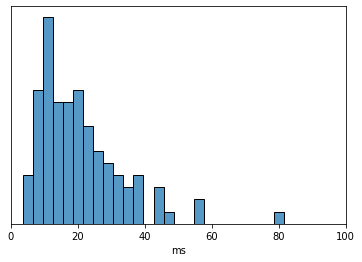

In [8]:
#Model visualizations (pre-training) -----  

# #All layers and associated parameters
# for name, param in net.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param} \n")

#Membrane time constant distribution
#Define plot + parameters
tau = (-time_step / np.log(het_tau.cpu())) / 1e-3
fig, ax = plt.subplots()
tc_distribution = sns.histplot(data = tau, kde = False, ax = ax, binwidth = 3)

#Set x-axis limit and remove y-axis
ax.set_xlim(0,100)
ax.axes.get_yaxis().set_visible(False)
plt.xlabel('ms')

In [9]:
#Optimizer and loss function -----

import snntorch.functional as SF

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3, betas = (0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate = 0.8, incorrect_rate = 0.2)

In [10]:
#Distance matrix -----

network_structure = [5, 5, 4]
distance_metric = 'euclidean'
distance_power = 1

nx = np.arange(network_structure[0])
ny = np.arange(network_structure[1])
nz = np.arange(network_structure[2])

[x,y,z] = np.meshgrid(nx,ny,nz)
coordinates = [x.ravel(),y.ravel(),z.ravel()]

euclidean_vector = scipy.spatial.distance.pdist(np.transpose(coordinates), metric=distance_metric)
euclidean = scipy.spatial.distance.squareform(euclidean_vector**distance_power)
distance_matrix = euclidean.astype('float32')

distance_matrix = torch.from_numpy(distance_matrix).to(device)

In [11]:
#Diagnostic tests -----

from scipy.stats import pearsonr

#Test for spatial regularization
def test_euclidean(x, y):
    x = torch.abs(x)
    x_array = x.cpu().detach().numpy()
    flat_x_array = x_array.flatten()
    y = torch.abs(y)
    y_array = y.cpu().detach().numpy()
    flat_y_array = y_array.flatten()
    correlation = pearsonr(flat_x_array, flat_y_array)[0]
    return correlation

print(f"Initial correlation between distance and weight matrices: {test_euclidean(distance_matrix, net.lif1.recurrent.weight)}")

Initial correlation between distance and weight matrices: -0.00720281738029272


In [12]:
#Training paradigm -----

#Training parameters
num_epochs = 50

#Regularization parameters
regu_strength = 10

#Initialize loss, accuracy, mean weights
loss_hist = []
acc_hist = []
feed_tot_hist = []
rec_tot_hist = []
corr_hist = []
test_acc_hist = []

#Pre-training extractions
acc_hist.append(0)
feed_tot_hist.append(torch.sum(torch.abs(net.fc1.weight.data)))
rec_tot_hist.append(torch.sum(torch.abs(net.lif1.recurrent.weight.data)))
corr_hist.append(test_euclidean(distance_matrix, net.lif1.recurrent.weight))

#Training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):

        #Load on CUDA (if available)
        data = data.to(device)
        targets = targets.to(device)

        #Set model to training mode
        net.train()
        spk_outputs, mem_outputs = net(data)

        #Spatial + L1 regularization
        abs_weight_matrix = torch.abs(net.lif1.recurrent.weight).to(device)
        spatial_L1_loss = regu_strength * torch.sum(torch.mul(abs_weight_matrix, distance_matrix))

        #Calculate loss
        loss_val = loss_fn(spk_outputs, targets) + spatial_L1_loss

        #Gradient calculation and weight updates
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        clip_tc(net.lif1.beta.data)

        #Store loss history
        loss_hist.append(loss_val.item())

    #Evaluations (every epoch)
    net.eval()

    #Report training loss
    print(f"Epoch {epoch} \nTraining Loss: {loss_val.item():.2f}")

    #Training accuracy
    acc = SF.accuracy_rate(spk_outputs, targets) #Outputs: [num_steps, batch_size, num_outputs]. Targets: [batch_size]
    acc_hist.append(acc)
    print(f"Training accuracy: {acc * 100:.2f}%")

    #Sum of feedforward weights
    feed_tot = torch.sum(torch.abs(net.fc1.weight.data))
    feed_tot_hist.append(feed_tot)
    print(f"Total feedforward weight: {feed_tot}")

    #Sum of recurrent weights
    rec_tot = torch.sum(torch.abs(net.lif1.recurrent.weight.data))
    rec_tot_hist.append(rec_tot)
    print(f"Total recurrent weight: {rec_tot}")

    #Correlation of distance and weight matrices
    corr_matrices = test_euclidean(distance_matrix, net.lif1.recurrent.weight)
    corr_hist.append(corr_matrices)
    print(f"Correlation of distance and weight matrices: {corr_matrices}")

    #Validation
    with torch.no_grad():
      net.eval()
      total = 0
      correct = 0

      for data, targets in testloader:

        data = data.to(device)
        targets = targets.to(device)

        test_spk, test_mem = net(data)

        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      test_acc_hist.append(100 * (correct / total))

    print(f'Total correctly classified test set images: {correct}/{total}')
    print(f'Test set accuracy: {100 * correct / total:.2f}%\n')


Epoch 0 
Training Loss: 7188.97
Training accuracy: 40.62%
Total feedforward weight: 18658.046875
Total recurrent weight: 233.44174194335938
Correlation of distance and weight matrices: -0.03176573398954598
Total correctly classified test set images: 82/256
Test set accuracy: 32.03%

Epoch 1 
Training Loss: 2026.59
Training accuracy: 53.12%
Total feedforward weight: 19879.82421875
Total recurrent weight: 67.66619873046875
Correlation of distance and weight matrices: -0.10180642113488475
Total correctly classified test set images: 109/256
Test set accuracy: 42.58%

Epoch 2 
Training Loss: 163.57
Training accuracy: 46.88%
Total feedforward weight: 20401.193359375
Total recurrent weight: 9.83381462097168
Correlation of distance and weight matrices: -0.22633078796324363
Total correctly classified test set images: 118/256
Test set accuracy: 46.09%

Epoch 3 
Training Loss: 48.73
Training accuracy: 62.50%
Total feedforward weight: 20831.896484375
Total recurrent weight: 6.196199417114258
Corre

In [13]:
#Test set accuracy -----

total = 0
correct = 0
dataloader = testloader

with torch.no_grad():
  net.eval()
  for data, targets in dataloader:
    data = data.to(device)
    targets = targets.to(device)

    #Forward pass
    test_spk, _ = net(data)

    #Calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 149/256
Test Set Accuracy: 58.20%


Layer: fc1.weight | Size: torch.Size([100, 32768]) | Values : Parameter containing:
tensor([[ 0.0015, -0.0054, -0.0076,  ..., -0.0098, -0.0044, -0.0027],
        [ 0.0004,  0.0096,  0.0109,  ..., -0.0024,  0.0062,  0.0078],
        [-0.0115, -0.0129,  0.0061,  ...,  0.0007, -0.0053, -0.0128],
        ...,
        [-0.0023, -0.0102, -0.0064,  ...,  0.0071, -0.0107,  0.0060],
        [ 0.0025,  0.0077,  0.0024,  ..., -0.0044,  0.0106,  0.0025],
        [ 0.0044,  0.0009, -0.0061,  ...,  0.0103,  0.0020, -0.0024]],
       device='cuda:0', requires_grad=True) 

Layer: fc1.bias | Size: torch.Size([100]) | Values : Parameter containing:
tensor([-0.0042,  0.0113, -0.0141, -0.0200,  0.0075,  0.0033,  0.0200,  0.0036,
        -0.0024,  0.0030,  0.0097,  0.0093,  0.0144,  0.0064,  0.0160,  0.0133,
        -0.0050, -0.0068, -0.0085,  0.0087,  0.0141,  0.0056, -0.0036, -0.0043,
        -0.0045,  0.0061, -0.0108, -0.0067,  0.0397,  0.0091, -0.0078,  0.0004,
        -0.0382,  0.0065,  0.0373,  0.002

Text(0.5, 0, 'ms')

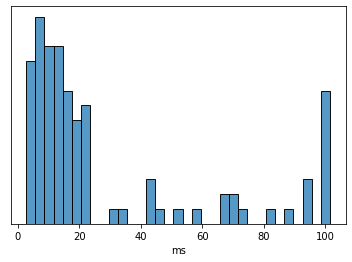

In [14]:
#Model visualizations (post-training) -----

#All layers and associated parameters
for name, param in net.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param} \n")

#Membrane time constant distribution
#Define plot + parameters
tau = (-time_step / np.log(net.lif1.beta.data.cpu())) / 1e-3
fig, ax = plt.subplots()
tc_distribution = sns.histplot(data = tau, kde = False, ax = ax, binwidth = 3)

#Visual modifications
ax.axes.get_yaxis().set_visible(False)
plt.xlabel('ms')

In [15]:
feed_tot_hist = torch.FloatTensor(feed_tot_hist)
rec_tot_hist = torch.FloatTensor(rec_tot_hist)
corr_hist = torch.FloatTensor(corr_hist)

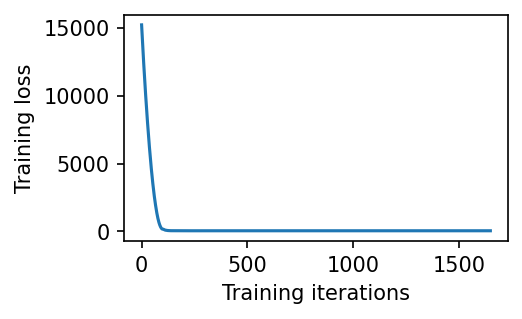

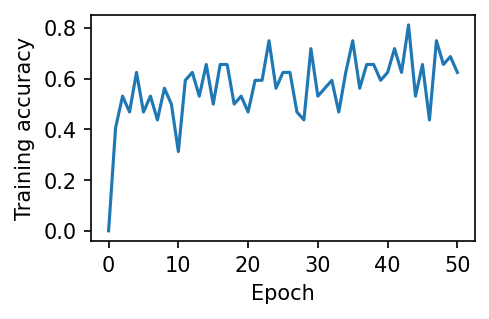

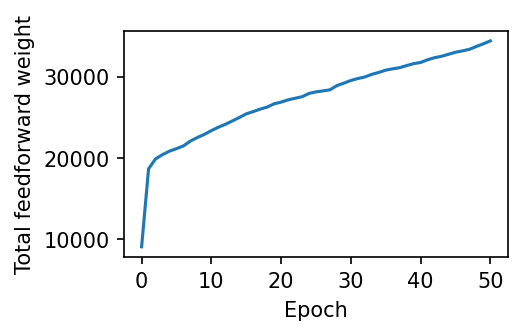

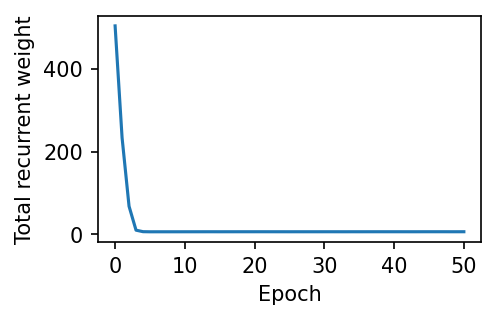

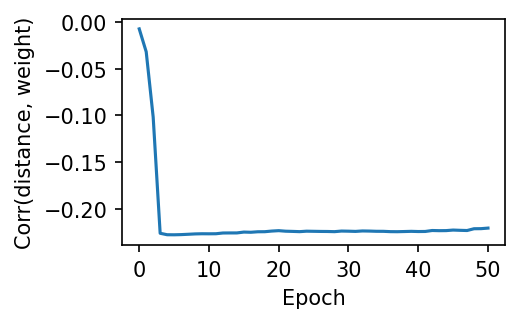

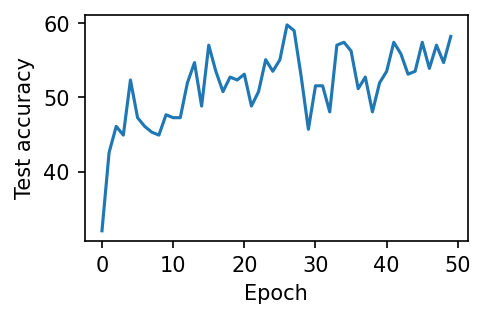

In [16]:
#Data visualizations -----

#Loss
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel('Training iterations')
plt.ylabel('Training loss')
plt.savefig('training_loss')

#Accuracy/performance
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(acc_hist)
plt.xlabel('Epoch')
plt.ylabel('Training accuracy')
plt.savefig('training_accuracy')

#Total feedforward weight
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(feed_tot_hist)
plt.xlabel('Epoch')
plt.ylabel('Total feedforward weight')
plt.savefig('total_feedforward_weight')

#Total recurrent weight
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(rec_tot_hist.cpu())
plt.xlabel('Epoch')
plt.ylabel('Total recurrent weight')
plt.savefig('total_recurrent_weight')

#Correlation of distance/weight matrices
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(corr_hist.cpu())
plt.xlabel('Epoch')
plt.ylabel('Corr(distance, weight)')
plt.savefig('correlation')

#Test set performance
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(test_acc_hist)
plt.xlabel('Epoch')
plt.ylabel('Test accuracy')
plt.savefig('test_accuracy')